In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy.stats import normaltest
from statsmodels.tsa.stattools import acf,pacf
from pmdarima.arima import auto_arima
import scipy.interpolate as sci
import scipy.optimize as sco
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import scipy.optimize as sco

In [2]:
df=pd.read_csv("INFOSYS.csv")

In [3]:
dff=pd.read_csv("INFOSYS.csv")

In [4]:
df.head()

,Date,Open,High,Low,Close,Volume
0,1/1/2015 15:30:00,492.24,495.50,489.23,493.60,500691
1,1/2/2015 15:30:00,493.00,504.76,493.00,503.30,1694580
2,1/5/2015 15:30:00,502.48,507.50,494.38,498.98,2484256
3,1/6/2015 15:30:00,495.00,496.25,483.53,488.55,2416829
4,1/7/2015 15:30:00,491.25,493.69,487.50,490.89,1812479


In [5]:
df['Date'] =pd.to_datetime(df['Date']).dt.date

In [6]:
df.head()

,Date,Open,High,Low,Close,Volume
0,2015-01-01,492.24,495.50,489.23,493.60,500691
1,2015-01-02,493.00,504.76,493.00,503.30,1694580
2,2015-01-05,502.48,507.50,494.38,498.98,2484256
3,2015-01-06,495.00,496.25,483.53,488.55,2416829
4,2015-01-07,491.25,493.69,487.50,490.89,1812479


In [7]:
df.set_index("Date", inplace = True)

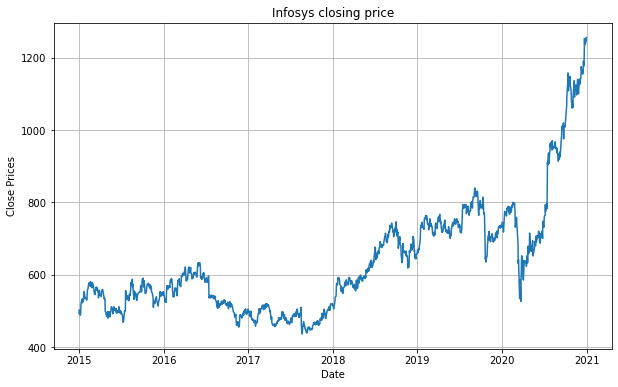

In [8]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('Infosys closing price')
plt.show()

<AxesSubplot:ylabel='Density'>

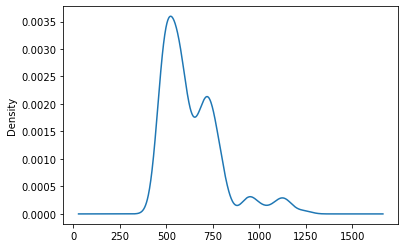

In [9]:
#Distribution of the dataset
df_close = df['Close']
df_close.plot(kind='kde')

In [10]:
# Define a function which will give us rolling mean and standard deviation and perform ADF Test
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.figure(figsize=(10,6))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

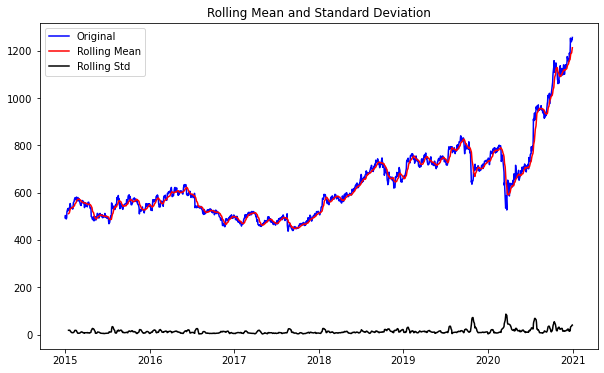

Results of dickey fuller test
Test Statistics                   1.485965
p-value                           0.997472
No. of lags used                  8.000000
Number of observations used    1472.000000
critical value (1%)              -3.434800
critical value (5%)              -2.863505
critical value (10%)             -2.567816
dtype: float64


In [11]:
test_stationarity(df['Close'])

'''Through the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.

In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.

So let us separate Trend and Seasonality from the time series'''

<Figure size 432x288 with 0 Axes>

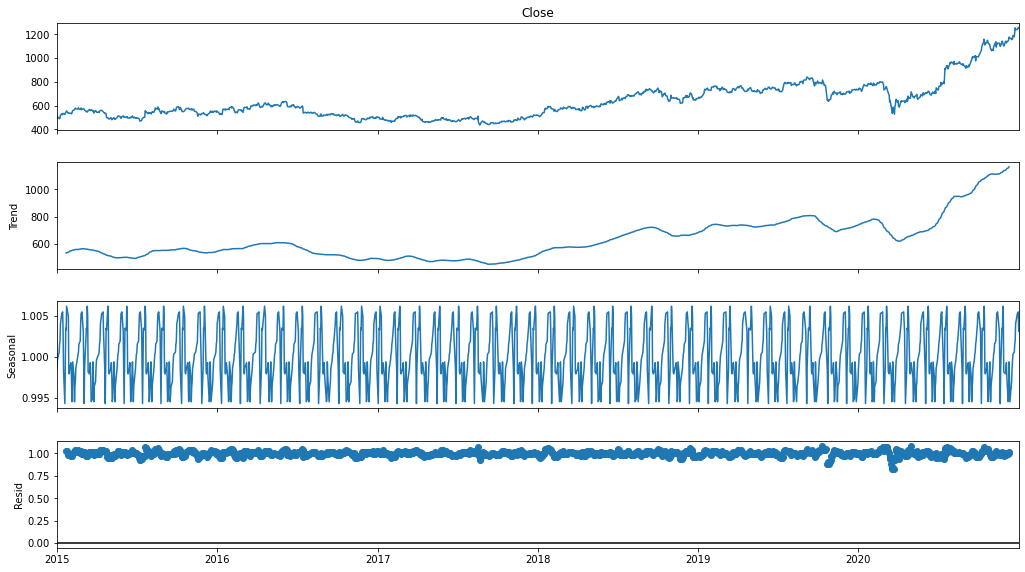

In [12]:
# Decompose the series to separate the trend and the seasonality from a time series, 
result = seasonal_decompose(df['Close'], model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

In [13]:
def test_stationarity(timeseries):
    # Transformation to make the data stationary
    timeseries_log = np.log(timeseries)
    timeseries_log_diff = timeseries_log.diff().dropna()

    # Determing rolling statistics
    rolmean = timeseries_log_diff.rolling(window=12).mean()
    rolstd = timeseries_log_diff.rolling(window=12).std()

    # Plot rolling statistics
    plt.figure(figsize=(10, 6))
    plt.plot(timeseries_log_diff, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.xlabel('Date')
    plt.ylabel('Log-Difference')
    plt.show()

    # Perform ADF test
    adft = adfuller(timeseries_log_diff, autolag='AIC')

    # Output the ADF test results
    output = pd.Series(adft[0:4], index=['Test Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used'])
    for key, value in adft[4].items():
        output[f'Critical Value ({key})'] = value
    print(output)

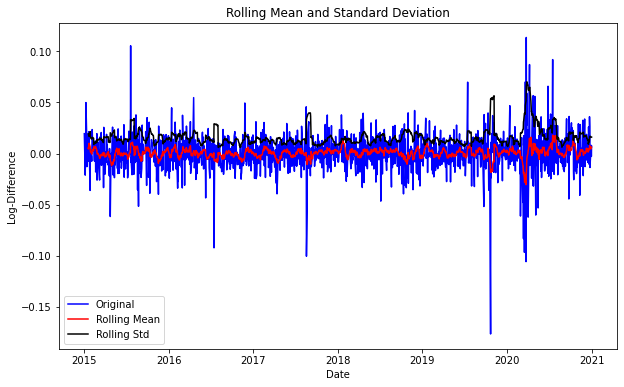

Test Statistic                -1.697072e+01
p-value                        9.163162e-30
Number of Lags Used            5.000000e+00
Number of Observations Used    1.474000e+03
Critical Value (1%)           -3.434794e+00
Critical Value (5%)           -2.863503e+00
Critical Value (10%)          -2.567815e+00
dtype: float64


In [14]:
test_stationarity(df['Close'])

Based on the ADF test results above, the test statistic is significantly lower than the critical values at all levels of significance (1%, 5%, and 10%). Additionally, the p-value is very close to zero, indicating strong evidence against the null hypothesis of non-stationarity.

Therefore, based on these results, we can conclude that the time series is stationary after the transformation.

In [15]:
import numpy as np

def moving_avg_prediction(data):
    shape = df.shape[0]
    df_new = df[['Close']]
    df_new['Close'] = np.log(df_new['Close'])  # Apply logarithmic transformation
    
    train_set = df_new.iloc[:ceil(shape * 0.9)]
    valid_set = df_new.iloc[ceil(shape * 0.9):]
    
    print('-----------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY MOVING AVERAGE--------')
    print('-----------------------------------------------------------')
    print('Shape of Training Set:', train_set.shape)
    print('Shape of Validation Set:', valid_set.shape)
    
    preds = []
    for i in range(0, valid_set.shape[0]):
        a = train_set['Close'][len(train_set) - valid_set.shape[0] + i:].sum() + sum(preds)
        b = a / (valid_set.shape[0])
        preds.append(b)
    
    rms = np.sqrt(np.mean(np.power((np.array(valid_set['Close']) - preds), 2)))
    print('RMSE value on validation set:', rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    
    valid_set['Predictions'] = preds
    plt.figure(figsize=(10, 6))
    plt.plot(train_set['Close'])
    plt.plot(valid_set[['Close', 'Predictions']])
    plt.xlabel('Date', size=20)
    plt.ylabel('Log-transformed Close Price', size=20)
    plt.title('Log-transformed Close Price Prediction by Moving Averages', size=20)
    plt.legend(['Model Training Data', 'Actual Data', 'Predicted Data'])

-----------------------------------------------------------
-----------STOCK PRICE PREDICTION BY MOVING AVERAGE--------
-----------------------------------------------------------
Shape of Training Set: (1333, 1)
Shape of Validation Set: (148, 1)
RMSE value on validation set: 0.37923810444518385
-----------------------------------------------------------
-----------------------------------------------------------


C:\Users\vikym\AppData\Local\Temp\ipykernel_9028\285369989.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Close'] = np.log(df_new['Close'])  # Apply logarithmic transformation
C:\Users\vikym\AppData\Local\Temp\ipykernel_9028\285369989.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_set['Predictions'] = preds


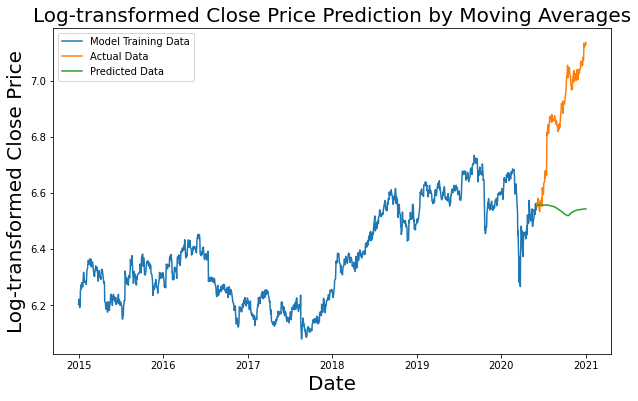

In [16]:
from math import ceil, floor
moving_avg_prediction(df)

In [17]:
from pmdarima.arima import auto_arima

# Auto ARIMA to select optimal ARIMA parameters
model = auto_arima(df['Close'], seasonal=False, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11475.465, Time=1.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11500.165, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11497.206, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11497.432, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11500.999, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11494.367, Time=0.69 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11500.308, Time=0.46 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=11479.657, Time=2.32 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=11478.927, Time=2.82 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11498.898, Time=0.42 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=11491.233, Time=1.56 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11489.999, Time=1.12 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=11479.368, Time=2.10 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=11476.439, Time=1.02 sec

Best model:  ARIMA

----------------------------------------------------------
-----------STOCK PRICE PREDICTION BY AUTO ARIMA-----------
----------------------------------------------------------
Shape of Training Set: (1111, 1)
Shape of Validation Set: (370, 1)
Performing stepwise search to minimize aic


C:\Users\vikym\AppData\Local\Temp\ipykernel_9028\1321657165.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Close'] = np.log(df_new['Close'])  # Apply logarithmic transformation


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6163.278, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6162.812, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6160.846, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6160.848, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6164.186, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6161.957, Time=0.34 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.548 seconds
RMSE value on validation set: 0.21849533041592364
-----------------------------------------------------------
-----------------------------------------------------------


C:\Users\vikym\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\vikym\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


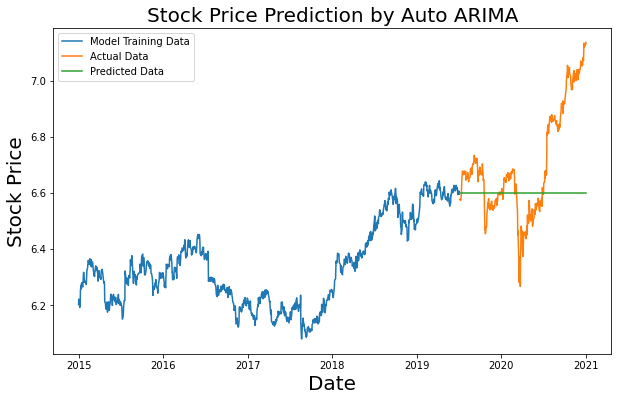

In [18]:
shape = df.shape[0]
df_new = df[['Close']]
df_new['Close'] = np.log(df_new['Close'])  # Apply logarithmic transformation
train_set = df_new.iloc[:ceil(shape * 0.75)]
valid_set = df_new.iloc[ceil(shape * 0.75):]
print('----------------------------------------------------------')
print('-----------STOCK PRICE PREDICTION BY AUTO ARIMA-----------')
print('----------------------------------------------------------')
print('Shape of Training Set:', train_set.shape)
print('Shape of Validation Set:', valid_set.shape)
training = train_set['Close']
validation = valid_set['Close']
model = auto_arima(training,seasonal=False, trace=True)
model.fit(training)
forecast = model.predict(n_periods=len(validation))
forecast.index = validation.index
forecast = pd.DataFrame(forecast,columns =['Prediction'])
#forecast = pd.DataFrame(forecast, index=valid_set.index, columns=['Prediction'])
rms = np.sqrt(np.mean(np.power((np.array(validation) - np.array(forecast['Prediction'])), 2)))
print('RMSE value on validation set:', rms)
print('-----------------------------------------------------------')
print('-----------------------------------------------------------')
plt.figure(figsize=(10, 6))
plt.plot(train_set['Close'])
plt.plot(valid_set['Close'])
plt.plot(forecast['Prediction'])
plt.xlabel('Date', size=20)
plt.ylabel('Stock Price', size=20)
plt.title('Stock Price Prediction by Auto ARIMA', size=20)
plt.legend(['Model Training Data', 'Actual Data', 'Predicted Data'])

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [20]:
shape = df.shape[0]
df_new=df[['Close']]
dataset = df_new.values
train = df_new.iloc[:ceil(shape * 0.8)]
valid = df_new.iloc[ceil(shape * 0.8):]
print('-----------------------------------------------------------------------------')
print('-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------')
print('-----------------------------------------------------------------------------')
print('Shape of Training Set',train.shape)
print('Shape of Validation Set',valid.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_new)

-----------------------------------------------------------------------------
-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------
-----------------------------------------------------------------------------
Shape of Training Set (1185, 1)
Shape of Validation Set (296, 1)


In [21]:
x_train, y_train = [], []
for i in range(40,len(train)):
    x_train.append(scaled_data[i-40:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=15, batch_size=1, verbose=2)

Epoch 1/15
1145/1145 - 16s - loss: 9.2155e-04 - 16s/epoch - 14ms/step
Epoch 2/15
1145/1145 - 11s - loss: 4.5669e-04 - 11s/epoch - 9ms/step
Epoch 3/15
1145/1145 - 10s - loss: 3.4606e-04 - 10s/epoch - 9ms/step
Epoch 4/15
1145/1145 - 11s - loss: 2.8387e-04 - 11s/epoch - 9ms/step
Epoch 5/15
1145/1145 - 11s - loss: 2.4420e-04 - 11s/epoch - 9ms/step
Epoch 6/15
1145/1145 - 11s - loss: 2.4905e-04 - 11s/epoch - 9ms/step
Epoch 7/15
1145/1145 - 11s - loss: 2.4558e-04 - 11s/epoch - 9ms/step
Epoch 8/15
1145/1145 - 11s - loss: 2.3702e-04 - 11s/epoch - 9ms/step
Epoch 9/15
1145/1145 - 10s - loss: 2.2896e-04 - 10s/epoch - 9ms/step
Epoch 10/15
1145/1145 - 11s - loss: 2.0481e-04 - 11s/epoch - 9ms/step
Epoch 11/15
1145/1145 - 11s - loss: 2.0425e-04 - 11s/epoch - 9ms/step
Epoch 12/15
1145/1145 - 11s - loss: 2.1002e-04 - 11s/epoch - 9ms/step
Epoch 13/15
1145/1145 - 11s - loss: 2.1577e-04 - 11s/epoch - 9ms/step
Epoch 14/15
1145/1145 - 11s - loss: 2.0676e-04 - 11s/epoch - 9ms/step
Epoch 15/15
1145/1145 - 11s 

In [22]:
inputs = df_new[len(df_new) - len(valid) - 40:]
inputs
inputs.values.reshape(-1,1)
inputs  = scaler.transform(inputs)
X_test = []
for i in range(40,inputs.shape[0]):
    X_test.append(inputs[i-40:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
opening_price = model.predict(X_test)
opening_price= scaler.inverse_transform(opening_price)
rms=np.sqrt(np.mean(np.power((valid-opening_price),2)))
print('RMSE value on validation set:',rms)

10/10 [==============================] - 1s 5ms/step
RMSE value on validation set: Close    23.496158
dtype: float64


C:\Users\vikym\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


C:\Users\vikym\AppData\Local\Temp\ipykernel_9028\4217257225.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = opening_price


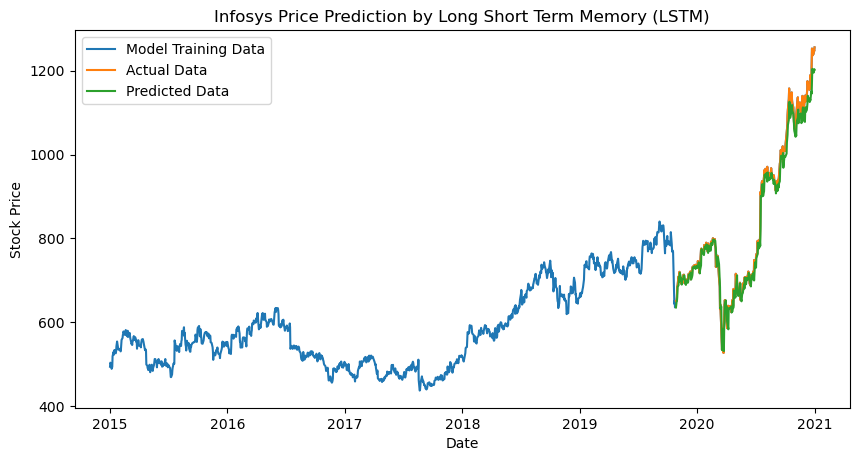

In [23]:
#Visualize the prediction
plt.figure(figsize=(10,5), dpi=100)
valid['Predictions'] = opening_price
plt.plot(df_new['Close'])
plt.plot(valid[['Close','Predictions']])
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Infosys Price Prediction by Long Short Term Memory (LSTM)')
plt.legend(['Model Training Data','Actual Data','Predicted Data'])